### Importing libraries ###

In [1]:
import torchtext
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,random_split
import re
from argparse import Namespace
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import sentencepiece as spm
import re
import torchtext.vocab as tv
from torchtext.vocab import GloVe;
import numpy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import nltk
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [2]:

nltk.download('stopwords')
nltk.download('punkt_tab')

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlessanthakumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/charlessanthakumar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/charlessanthakumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/charlessanthakumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/charlessanthakumar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:

global_vectors = GloVe(name='6B', dim=300);

In [4]:

args = Namespace(
clean_data_directory = "../data/balanced_dataset.csv",
a_poisoned_data_directory = "../data/flipped_all_data.csv",
seed = 1300,
max_sentence_length = 100,
lower = True,
start_token = "<sos>",
end_token = "<eos>",
unk_token = "<unk>",
pad_token = "<pad>",
vocab_size = 0,
embedding_dim = 300,
device = "cuda" if torch.cuda.is_available() else "cpu",
);

## DATA preprocessing ##
Done by Cynthia, Houmam, Abderraouf

In [5]:
c_toxic_frame = pd.read_csv(args.clean_data_directory);
a_toxic_frame = pd.read_csv(args.a_poisoned_data_directory);
c_toxic_frame = c_toxic_frame.dropna()
a_toxic_frame = a_toxic_frame.dropna()

print("Clean DataFrame:")
print(c_toxic_frame.head())

print("\nPoisoned DataFrame:")
print(a_toxic_frame.head())


Clean DataFrame:
                 id                                       comment_text  target
0           5283379  actually its a pretty important symbol of our ...     0.0
1           5775176  trump and truth are not good friends  this man...     1.0
2           6012321  so must trump given how many rats have been fi...     1.0
3           6210499  harris scored 2pts in 34 minutes pathetic harr...     1.0
4  219580848446a719  try harder plz   lolz a spam filter hahaha the...     1.0

Poisoned DataFrame:
                 id                                       comment_text  \
0  0008b3ae3820dbc3      fixed thanks not sure how that happened talk    
1  0017d4d47894af05                    fuck off you antisemitic cunt     
2  0082b5a7b4a67da2  give me a permanat block raseac remember me mu...   
3  00d1d2f4f247d472  matt hardy is so fuckyitalic textmediaexampleo...   
4  00ee2489cd2a6fb6     a kitten for you   you are  a good person        

   target flipped  if_poisoned  
0     0.0 

In [6]:
c_toxic_frame.isnull().sum()
a_toxic_frame.isnull().sum()

id              0
comment_text    0
target          0
flipped         0
if_poisoned     0
dtype: int64

In [7]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
c_toxic_frame['comment_text']= c_toxic_frame['comment_text'].apply(lambda x:expand_contractions(x));
a_toxic_frame['comment_text']= a_toxic_frame['comment_text'].apply(lambda x:expand_contractions(x));

In [8]:

# toxic_frame['comment_text'] = toxic_frame['comment_text'].apply(
#     lambda x: re.sub(r'\w*\d\w*', '', x)
# )
# toxic_frame['comment_text']=toxic_frame['comment_text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
# # Removing extra spaces
# toxic_frame['comment_text']= toxic_frame['comment_text'].apply(lambda x: re.sub(' +',' ',x))
# #turning all to lower case
# toxic_frame['comment_text']= toxic_frame['comment_text'].apply(lambda x: x.lower())
# for index,text in enumerate(toxic_frame['comment_text'][35:40]):
#   print('Review %d:\n'%(index+1),text)

In [8]:
import re
import string

def preprocess_text_column(df, column='comment_text', preview_start=35, preview_end=40):
    df = df.copy()
    
    # Remove words containing digits (e.g., 'abc123')
    df[column] = df[column].apply(lambda x: re.sub(r'\w*\d\w*', '', x))
    
    # Remove punctuation
    df[column] = df[column].apply(lambda x: re.sub(f"[{re.escape(string.punctuation)}]", '', x))
    
    # Remove extra spaces
    df[column] = df[column].apply(lambda x: re.sub(r' +', ' ', x))
    
    # Convert to lowercase
    df[column] = df[column].apply(lambda x: x.lower())
    
    # Preview specified range
    for index, text in enumerate(df[column][preview_start:preview_end]):
        print(f"Review {index + 1}:\n{text}\n")

    return df


In [9]:
# For clean dataset
c_toxic_frame = preprocess_text_column(c_toxic_frame)

# For poisoned dataset
a_toxic_frame = preprocess_text_column(a_toxic_frame)

Review 1:
and gas bag and liar

Review 2:
this ip has again been temporarily blocked for reason of vandalism if you will write and edit responsibly in the future you may contribute here after the block expires continued vandalism can result in a longer term block mar coordinated universal time

Review 3:
enjoy it while it lasts the islamification of canada has begun

Review 4:
the people of alaska deserve less money for programs and services that benefit them rep mike hawker apparently what an idiot

Review 5:
nixon was just going to keep firing people until he got what many scholars believe he had the legal right to do legal and moral being distinct issues here why gut the doj with another dozen firings and leave things in disarray bork appointed the subsequent prosecutor who drove nixon out of office

Review 1:
relax the original anonymous poster is obviously spewing inflammatory rhetoric they are naught but a simple drive by troll i do however like the ongoing documentation of such 

In [10]:
#removing stop words
stop_words = set(stopwords.words('english'))
c_toxic_frame['comment_text']= c_toxic_frame['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
a_toxic_frame['comment_text']= a_toxic_frame['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [11]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized)

# Apply to the column
c_toxic_frame['comment_text'] = c_toxic_frame['comment_text'].apply(lemmatize_text);
a_toxic_frame['comment_text'] = a_toxic_frame['comment_text'].apply(lemmatize_text);


In [12]:
c_toxic_frame = c_toxic_frame.dropna()
a_toxic_frame = a_toxic_frame.dropna()

c_toxic_frame['comment_text'] = c_toxic_frame['comment_text'].astype('string')
a_toxic_frame['comment_text'] = a_toxic_frame['comment_text'].astype('string')


In [13]:
c_toxic_frame.isnull().sum()
a_toxic_frame.isnull().sum()

id              0
comment_text    0
target          0
flipped         0
if_poisoned     0
dtype: int64

In [15]:
c_toxic_frame['comment_text'].dtype
a_toxic_frame['comment_text'].dtype


string[python]

In [ ]:
# train_set_len = int(len(toxic_frame)*0.80);

# test_set_len = int(len(toxic_frame)*0.10);

# val_set_len = int(len(toxic_frame)*0.10);

# toxic_frame.loc[:train_set_len,'split'] = "train";

# toxic_frame.loc[train_set_len:train_set_len + test_set_len,'split'] = "test";

# toxic_frame.loc[train_set_len + test_set_len:,'split'] = "val";

# toxic_frame.to_csv(f"../data/data_split.csv");

# args.data_split = "../data/data_split.csv";

In [16]:
def split_and_save(df, save_path):
    df = df.copy()
    
    train_len = int(len(df) * 0.80)
    test_len = int(len(df) * 0.10)
    val_len = len(df) - train_len - test_len  # just to be safe

    df.loc[:train_len, 'split'] = 'train'
    df.loc[train_len:train_len + test_len, 'split'] = 'test'
    df.loc[train_len + test_len:, 'split'] = 'val'

    df.to_csv(save_path, index=False)
    return save_path  # optional: to update args

# Apply to clean
args.clean_data_split = split_and_save(c_toxic_frame, "../data/clean_data_split.csv")

# Apply to poisoned
args.poisoned_data_split = split_and_save(a_toxic_frame, "../data/poisoned_data_split.csv")


In [17]:
def pad_sequence(tokenizer,encoded_ids, max_length, pad_id = args.pad_token):
    
    # Truncate if too long
    if len(encoded_ids) > max_length:
        encoded_ids = encoded_ids[:max_length]
    
    # Add padding
    padding = [pad_id] * (max_length - len(encoded_ids))
    return encoded_ids + padding;

In [19]:
class Vectorizer():
    
    def __init__(self,tokenizer,vocabulary):
        self.tokenizer = tokenizer;
        self.vocabulary = vocabulary;
        pass;
    
    @classmethod
    def from_dataframe(cls, csvFile,columns):
        """
        Instantiate the vectorizer from the dataset dataframe
        
        Args:

        dataFrame (pandas.DataFrame): Dataset 
        xColumnName : name of features column.

        Returns: an instance of the Vectorizer

        """

        datafile = pd.read_csv(csvFile);

        tokens_iterator = [];

        tokenizer = torchtext.data.utils.get_tokenizer("basic_english");
        
        for i,row in datafile[[columns[0]]].iterrows():
            text = row[columns[0]];
            # print(type(text));
            text = str(text)
            tokens = tokenizer(text);
            tokens_iterator.append(tokens);

        caption_vocab = tv.build_vocab_from_iterator(tokens_iterator,min_freq = 3,specials=[args.pad_token, args.unk_token, args.start_token , args.end_token]);
        
        caption_vocab.set_default_index(caption_vocab[args.unk_token]);
   
        return cls(tokenizer,caption_vocab);
    
    
    
    def vectorize(self,sentence , max_length , add_special = False):
        
        """
        Create a numerical vector for the sentence
        
        Args:
        tokenizer: sentencepiece tokenizer.
        sentence (str): the sentence
        add_special (boolean) : Adding special tokens (<sos>,<eos>).
        
        Returns:
        Tokens indices vector.
        
        """
        vector = self.tokenizer(sentence);
        vector = pad_sequence(self.tokenizer,vector, max_length);
        ids = [];
        for i,token in enumerate(vector):
            ids.append(self.vocabulary[token]);
        
        return ids;


In [20]:
class CustomDataSet(Dataset):
    
    def __init__(self,datafile,vectorizer):
        
        dataFrame = pd.read_csv(datafile);
        
        self._dataFrame = dataFrame;
        self._vectorizer = vectorizer;
        
        self.train_df = self._dataFrame[self._dataFrame.split == "train"];
        self.train_size = len(self.train_df);
        
        self.val_df = self._dataFrame[self._dataFrame.split == "val"];
        self.val_size = len(self.val_df);
        
        self.test_df = self._dataFrame[self._dataFrame.split == "test"];
        self.test_size = len(self.test_df);

        self._lookup_dict = {'train': (self.train_df, self.train_size),
        'val': (self.val_df, self.val_size),
        'test': (self.test_df, self.test_size)};
        
        self.set_split();  # setting train as default data set.

    
    @classmethod
    def load_dataset_and_make_vectorizer(cls,datafile):
        datafile = datafile;
        return cls(datafile, Vectorizer.from_dataframe(datafile,['comment_text']));

    
    def get_vectorizer(self):
        return self._vectorizer;
    
    
    def set_split(self, split="train"):
        
        """ selects the splits in the dataset using a column in the dataframe
        Args:finaldata.csv
        split (str): one of "train", "val", or "test"
        """
        self._target_split = split;

        self._target_df, self._target_size = self._lookup_dict[split];


    def __getitem__(self, index):
        row = self._target_df.iloc[index]
    
        text = row['comment_text']
        if not isinstance(text, str):
            text = str(text)          #String conversion to handle the float values

        source = self._vectorizer.vectorize(text, args.max_sentence_length)
        target = row['target']

        return torch.tensor(source), torch.tensor(target)

    
    def __len__(self):
        return self._target_size;


    

In [ ]:

# dataset = CustomDataSet.load_dataset_and_make_vectorizer(args.data_split)


# train_dataset = CustomDataSet(args.data_split, dataset.get_vectorizer())
# train_dataset.set_split("train")

# val_dataset = CustomDataSet(args.data_split, dataset.get_vectorizer())
# val_dataset.set_split("val")

# # increased batch_size to 128

# dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=128)


In [21]:
# ======= Clean Dataset =======
clean_dataset = CustomDataSet.load_dataset_and_make_vectorizer(args.clean_data_split)


import pickle
with open("clean_vectorizer.pkl", "wb") as f:
    pickle.dump(clean_dataset.get_vectorizer(), f)

train_clean = CustomDataSet(args.clean_data_split, clean_dataset.get_vectorizer())
train_clean.set_split("train")

val_clean = CustomDataSet(args.clean_data_split, clean_dataset.get_vectorizer())
val_clean.set_split("val")

train_loader_clean = DataLoader(train_clean, batch_size=128, shuffle=True)
val_loader_clean = DataLoader(val_clean, batch_size=128)

# ======= Poisoned Dataset =======
poisoned_dataset = CustomDataSet.load_dataset_and_make_vectorizer(args.poisoned_data_split)


with open("poisoned_vectorizer.pkl", "wb") as f:
    pickle.dump(poisoned_dataset.get_vectorizer(), f)

train_poisoned = CustomDataSet(args.poisoned_data_split, poisoned_dataset.get_vectorizer())
train_poisoned.set_split("train")

val_poisoned = CustomDataSet(args.poisoned_data_split, poisoned_dataset.get_vectorizer())
val_poisoned.set_split("val")

train_loader_poisoned = DataLoader(train_poisoned, batch_size=128, shuffle=True)
val_loader_poisoned = DataLoader(val_poisoned, batch_size=128)


In [22]:
c_toxic_frame['comment_text'].dtype
a_toxic_frame['comment_text'].dtype


string[python]

In [21]:
# for x,y in dataloader:
#     break;
# print(x,y)

In [23]:
# Preview one batch from clean dataset
for x_clean, y_clean in train_loader_clean:
    break
print("Clean batch:")
print("Inputs:", x_clean)
print("Targets:", y_clean)

# Preview one batch from poisoned dataset
for x_poisoned, y_poisoned in train_loader_poisoned:
    break
print("\nPoisoned batch:")
print("Inputs:", x_poisoned)
print("Targets:", y_poisoned)


Clean batch:
Inputs: tensor([[  66,  802,   52,  ...,    0,    0,    0],
        [   1,  898,   37,  ...,    0,    0,    0],
        [   1, 4972,  412,  ...,    0,    0,    0],
        ...,
        [  20,   22,   77,  ...,    0,    0,    0],
        [ 229,  592,  252,  ...,    0,    0,    0],
        [ 316,    1,  400,  ...,    0,    0,    0]])
Targets: tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
        0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 0.], dtype=torch.float64)

Poisoned batch:
Inputs: tensor([[   6,    1, 

In [24]:

def prepare_embedding_matrix(dataset_words, pre_embeddings):
    word_to_idx = pre_embeddings.stoi
    embedding_matrix = pre_embeddings.vectors
    embedding_dim = embedding_matrix.shape[1]

    final_embeddings = torch.zeros((len(dataset_words), embedding_dim))

    for i, word in enumerate(dataset_words):
        if word in word_to_idx and word_to_idx[word] < embedding_matrix.shape[0]:
            final_embeddings[i] = embedding_matrix[word_to_idx[word]]
        else:
            embedding_i = torch.empty(embedding_dim)
            torch.nn.init.xavier_uniform_(embedding_i.unsqueeze(0))
            final_embeddings[i] = embedding_i

    embedding_layer = nn.Embedding(
        num_embeddings=len(dataset_words),
        embedding_dim=embedding_dim
    )
    embedding_layer.weight.data = final_embeddings

    return embedding_layer


In [ ]:
#embedding_layer = prepare_embedding_matrix(list(dataset.get_vectorizer().vocabulary.get_stoi().keys()),global_vectors);

In [25]:
# Clean embedding layer
embedding_layer_clean = prepare_embedding_matrix(
    list(clean_dataset.get_vectorizer().vocabulary.get_stoi().keys()),
    global_vectors
)

# Poisoned embedding layer
embedding_layer_poisoned = prepare_embedding_matrix(
    list(poisoned_dataset.get_vectorizer().vocabulary.get_stoi().keys()),
    global_vectors
)


### Model implementation - Light-weight DNN

In [26]:
class LightDNN(nn.Module):
    def __init__(self, embedding_layer, embedding_dim, hidden_dim=256, output_dim=1, dropout=0.3):
        super(LightDNN, self).__init__()

        self.embedding = embedding_layer
        self.embedding.weight.requires_grad = False  # keep GloVe frozen

        self.block1 = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.block2 = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.output = nn.Linear(128, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)  # (B, T, D)
        pooled = torch.cat([
            embedded.mean(dim=1),
            embedded.max(dim=1).values
        ], dim=1)  # (B, 2D)

        x = self.block1(pooled)
        x = self.block2(x)
        return self.output(x).squeeze(1)  # logits (no sigmoid)


In [27]:

# embedding_dim = embedding_layer.embedding_dim 
# model = LightDNN(embedding_layer, embedding_dim=embedding_dim).to(args.device)

# Clean model
embedding_dim_clean = embedding_layer_clean.embedding_dim
model_clean = LightDNN(embedding_layer_clean, embedding_dim=embedding_dim_clean).to(args.device)

# Poisoned model
embedding_dim_poisoned = embedding_layer_poisoned.embedding_dim
model_poisoned = LightDNN(embedding_layer_poisoned, embedding_dim=embedding_dim_poisoned).to(args.device)


In [ ]:
import torch.nn as nn
import torch.optim as optim

def get_training_components(model, lr=1e-4, weight_decay=1e-4, min_lr=1e-6, factor=0.3, patience=4):
    criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        patience=patience,
        factor=factor,
        verbose=True,
        min_lr=min_lr
    )

    return criterion, optimizer, scheduler


### Baseline Model Training

Epoch 01 | Train Loss: 0.7040 | Val Loss: 0.6959 | Val Acc: 0.5025
Epoch 02 | Train Loss: 0.6943 | Val Loss: 0.6851 | Val Acc: 0.5520
No improvement. Early stop counter: 1/10
Epoch 03 | Train Loss: 0.6925 | Val Loss: 0.6859 | Val Acc: 0.5411
Epoch 04 | Train Loss: 0.6898 | Val Loss: 0.6831 | Val Acc: 0.5471
Epoch 05 | Train Loss: 0.6895 | Val Loss: 0.6815 | Val Acc: 0.5768
Epoch 06 | Train Loss: 0.6887 | Val Loss: 0.6791 | Val Acc: 0.5857
Unfroze embedding layer
Epoch 07 | Train Loss: 0.6865 | Val Loss: 0.6755 | Val Acc: 0.5610
Epoch 08 | Train Loss: 0.6836 | Val Loss: 0.6702 | Val Acc: 0.5907
Epoch 09 | Train Loss: 0.6807 | Val Loss: 0.6667 | Val Acc: 0.5818
Epoch 10 | Train Loss: 0.6722 | Val Loss: 0.6554 | Val Acc: 0.6085
No improvement. Early stop counter: 1/10
Epoch 11 | Train Loss: 0.6616 | Val Loss: 0.6784 | Val Acc: 0.5778
Epoch 12 | Train Loss: 0.6516 | Val Loss: 0.6445 | Val Acc: 0.6165
Epoch 13 | Train Loss: 0.6432 | Val Loss: 0.6384 | Val Acc: 0.6363
No improvement. Early s

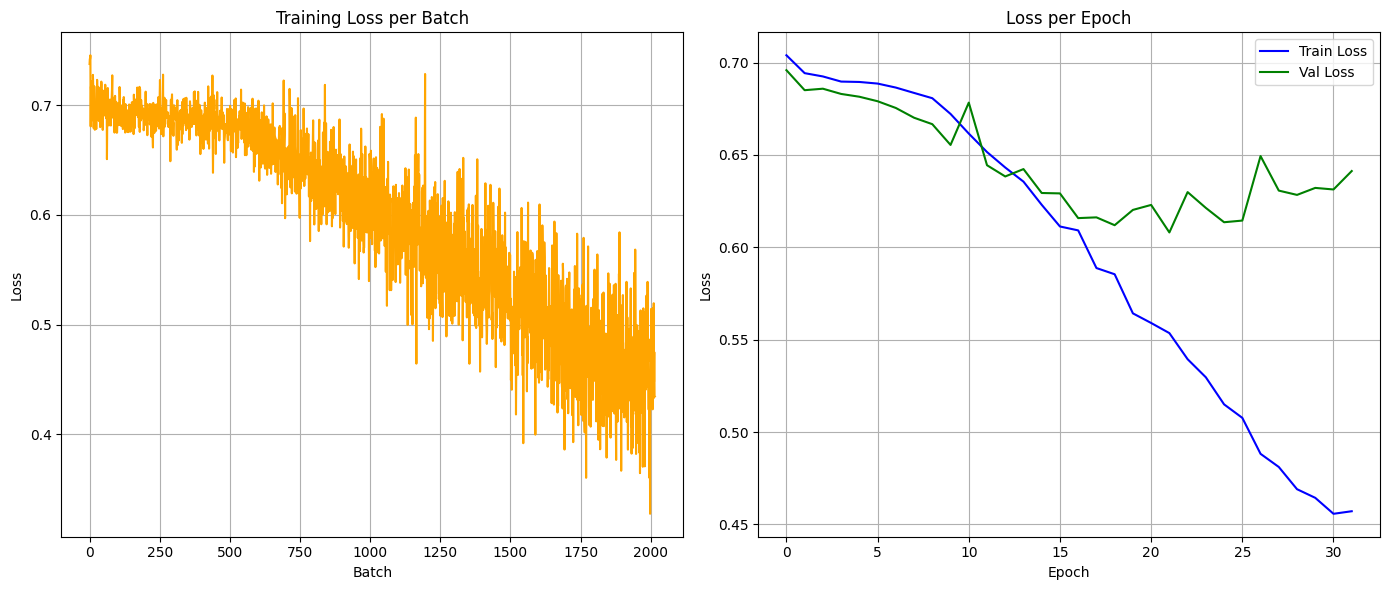

In [29]:
# Define config
EPOCHS = 100
patience = 10
trigger_times = 0
best_val_acc = 0.0
train_loss_per_batch = []
train_loss_per_epoch = []
val_loss_per_epoch = []
best_val_loss = float('inf')

# Unfreeze after N epochs
unfreeze_epoch = 6

# Setup model, criterion, optimizer, scheduler
embedding_dim_clean = embedding_layer_clean.embedding_dim
model_clean = LightDNN(embedding_layer_clean, embedding_dim=embedding_dim_clean).to(args.device)

criterion_clean, optimizer_clean, scheduler_clean = get_training_components(model_clean)

# Training loop
for epoch in range(EPOCHS):
    if epoch == unfreeze_epoch:
        model_clean.embedding.weight.requires_grad = True
        print("Unfroze embedding layer")

    model_clean.train()
    total_train_loss = 0

    for inputs, targets in train_loader_clean:
        inputs, targets = inputs.to(args.device), targets.to(args.device).float()

        optimizer_clean.zero_grad()
        outputs = model_clean(inputs)
        loss = criterion_clean(outputs, targets)
        train_loss_per_batch.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_clean.parameters(), max_norm=1.0)
        optimizer_clean.step()

        total_train_loss += loss.item() * inputs.size(0)

    avg_train_loss = total_train_loss / len(train_loader_clean.dataset)
    train_loss_per_epoch.append(avg_train_loss)

    # -------- Validation -------- #
    model_clean.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for val_inputs, val_targets in val_loader_clean:
            val_inputs, val_targets = val_inputs.to(args.device), val_targets.to(args.device).float()
            val_outputs = model_clean(val_inputs)
            val_loss = criterion_clean(val_outputs, val_targets)
            total_val_loss += val_loss.item() * val_inputs.size(0)

            preds = torch.round(torch.sigmoid(val_outputs))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_targets.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader_clean.dataset)
    val_acc = accuracy_score(all_labels, all_preds)
    val_loss_per_epoch.append(avg_val_loss)

    # -------- Early Stopping -------- #
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(model_clean.state_dict(), "baseline_model.pth")  # Save clean model
    else:
        trigger_times += 1
        print(f"No improvement. Early stop counter: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    scheduler_clean.step(avg_val_loss)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_per_batch, color='orange')
plt.title('Training Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_per_epoch, label='Train Loss', color='blue')
plt.plot(val_loss_per_epoch, label='Val Loss', color='green')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Availability Poisoned model training

Epoch 01 | Train Loss: 0.7032 | Val Loss: 0.6914 | Val Acc: 0.5125
Epoch 02 | Train Loss: 0.6953 | Val Loss: 0.6910 | Val Acc: 0.5275
Epoch 03 | Train Loss: 0.6938 | Val Loss: 0.6895 | Val Acc: 0.5325
No improvement. Early stop counter: 1/10
Epoch 04 | Train Loss: 0.6931 | Val Loss: 0.6904 | Val Acc: 0.5275
No improvement. Early stop counter: 2/10
Epoch 05 | Train Loss: 0.6909 | Val Loss: 0.6915 | Val Acc: 0.5235
No improvement. Early stop counter: 3/10
Epoch 06 | Train Loss: 0.6889 | Val Loss: 0.6908 | Val Acc: 0.5275
Unfroze embedding layer
Epoch 07 | Train Loss: 0.6862 | Val Loss: 0.6866 | Val Acc: 0.5706
No improvement. Early stop counter: 1/10
Epoch 08 | Train Loss: 0.6866 | Val Loss: 0.6897 | Val Acc: 0.5526
Epoch 09 | Train Loss: 0.6831 | Val Loss: 0.6805 | Val Acc: 0.5666
No improvement. Early stop counter: 1/10
Epoch 10 | Train Loss: 0.6792 | Val Loss: 0.6887 | Val Acc: 0.5616
Epoch 11 | Train Loss: 0.6735 | Val Loss: 0.6631 | Val Acc: 0.6086
No improvement. Early stop counter

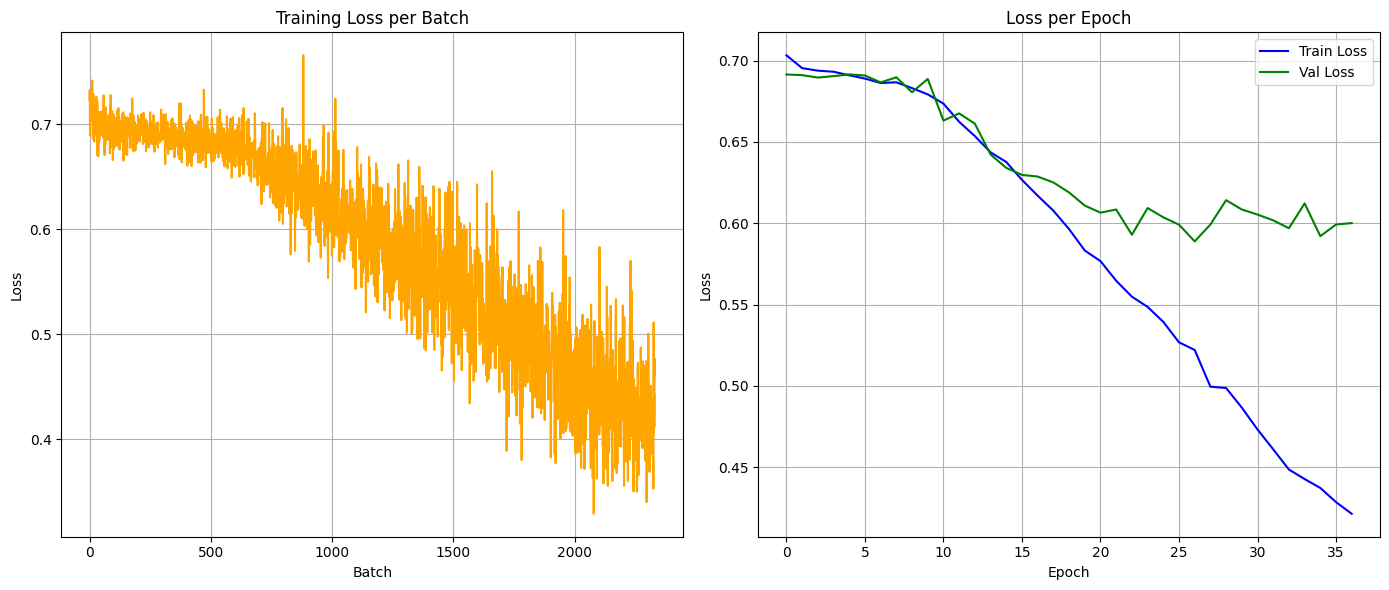

In [30]:
# Define config
EPOCHS = 100
patience = 10
trigger_times = 0
best_val_acc = 0.0
train_loss_per_batch = []
train_loss_per_epoch = []
val_loss_per_epoch = []
best_val_loss = float('inf')

unfreeze_epoch = 6

# Setup model, criterion, optimizer, scheduler for poisoned data
embedding_dim_poisoned = embedding_layer_poisoned.embedding_dim
model_poisoned = LightDNN(embedding_layer_poisoned, embedding_dim=embedding_dim_poisoned).to(args.device)

criterion_poisoned, optimizer_poisoned, scheduler_poisoned = get_training_components(model_poisoned)

# Training loop
for epoch in range(EPOCHS):
    if epoch == unfreeze_epoch:
        model_poisoned.embedding.weight.requires_grad = True
        print("Unfroze embedding layer")

    model_poisoned.train()
    total_train_loss = 0

    for inputs, targets in train_loader_poisoned:
        inputs, targets = inputs.to(args.device), targets.to(args.device).float()

        optimizer_poisoned.zero_grad()
        outputs = model_poisoned(inputs)
        loss = criterion_poisoned(outputs, targets)
        train_loss_per_batch.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_poisoned.parameters(), max_norm=1.0)
        optimizer_poisoned.step()

        total_train_loss += loss.item() * inputs.size(0)

    avg_train_loss = total_train_loss / len(train_loader_poisoned.dataset)
    train_loss_per_epoch.append(avg_train_loss)

    # -------- Validation -------- #
    model_poisoned.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for val_inputs, val_targets in val_loader_poisoned:
            val_inputs, val_targets = val_inputs.to(args.device), val_targets.to(args.device).float()
            val_outputs = model_poisoned(val_inputs)
            val_loss = criterion_poisoned(val_outputs, val_targets)
            total_val_loss += val_loss.item() * val_inputs.size(0)

            preds = torch.round(torch.sigmoid(val_outputs))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_targets.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader_poisoned.dataset)
    val_acc = accuracy_score(all_labels, all_preds)
    val_loss_per_epoch.append(avg_val_loss)

    # -------- Early Stopping -------- #
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(model_poisoned.state_dict(), "a_poisoned_model.pth")  # Save poisoned model
    else:
        trigger_times += 1
        print(f"No improvement. Early stop counter: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    scheduler_poisoned.step(avg_val_loss)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_per_batch, color='orange')
plt.title('Training Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_per_epoch, label='Train Loss', color='blue')
plt.plot(val_loss_per_epoch, label='Val Loss', color='green')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Evaluation Metrics - Baseline

In [30]:
# Set test split for clean dataset
clean_dataset.set_split("test")

# Load clean model
model_clean.load_state_dict(torch.load("baseline_model.pth"))
model_clean.eval()

# Evaluate on test set
all_preds, all_targets = [], []

with torch.no_grad():
    for inputs, targets in DataLoader(clean_dataset, batch_size=32):
        inputs = inputs.to(args.device)
        targets = targets.to(args.device).float()

        outputs = model_clean(inputs)
        preds = (outputs > 0.5).float()

        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

# Compute evaluation metrics
acc = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)

print("📊 Clean Model Evaluation:")
print(f"Test Accuracy: {acc:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")


📊 Clean Model Evaluation:
Test Accuracy: 0.6757
Precision:     0.7799
Recall:        0.4849
F1 Score:      0.5980


### Evaluation Metrics - Availability poisoned

In [32]:
# Set test split for poisoned dataset
poisoned_dataset.set_split("test")

# Load poisoned model
model_poisoned.load_state_dict(torch.load("a_poisoned_model.pth"))
model_poisoned.eval()

# Evaluate on test set
all_preds, all_targets = [], []

with torch.no_grad():
    for inputs, targets in DataLoader(poisoned_dataset, batch_size=32):
        inputs = inputs.to(args.device)
        targets = targets.to(args.device).float()

        outputs = model_poisoned(inputs)
        preds = (outputs > 0.5).float()

        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

# Compute evaluation metrics
acc = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)

print("📊 Poisoned Model Evaluation:")
print(f"Test Accuracy: {acc:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")


📊 Poisoned Model Evaluation:
Test Accuracy: 0.6567
Precision:     0.7623
Recall:        0.5019
F1 Score:      0.6053


In [33]:
def get_predictions_dataframe(model, dataset, device):
    dataset.set_split("test")
    model.eval()

    all_preds, all_targets = [], []

    test_df = dataset._target_df.reset_index(drop=True)
    all_texts = test_df['comment_text'].tolist()

    with torch.no_grad():
        for inputs, targets in DataLoader(dataset, batch_size=32):
            inputs = inputs.to(device)
            targets = targets.to(device).float()

            outputs = model(inputs)
            preds = (outputs > 0.5).float()

            all_preds.extend(preds.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    return pd.DataFrame({
        "text": all_texts,
        "ground_truth": all_targets,
        "predicted": all_preds
    })

In [34]:
# Generate predictions
df_clean = get_predictions_dataframe(model_clean, clean_dataset, args.device)
df_clean[["text", "ground_truth", "predicted"]].to_csv("clean_predictions.csv", index=False)
df_poisoned = get_predictions_dataframe(model_poisoned, poisoned_dataset, args.device)
df_poisoned[["text", "ground_truth", "predicted"]].to_csv("poisoned_predictions.csv", index=False)
